### Tasks
* Implement Faiss - (create a util file using code given by gaurav and import here) 
* Implement Near Neighbor Sampling 
* plot the gradients for each batch (==1, should be high) and for the entire dataset(should be low) at different interesting epochs 
* Figure out how to calculate efficient per sample gradient 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import time

#replace with pytorch lightning
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

from indx import *
from query import *

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
random.seed(123)

In [3]:
# device = torch.device("cpu")
# device = torch.device(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device(device)
print(device)

cuda:0


In [5]:
df=pd.read_csv("HIGGS.csv",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [6]:
#subsample
df = df[:600000]

In [7]:
print(df.size)

17400000


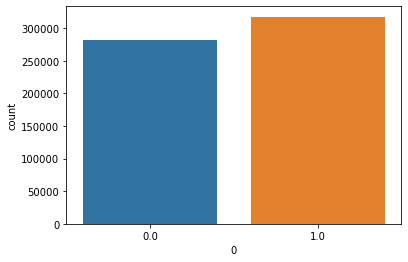

In [8]:
sns.countplot(x = 0, data=df)

In [9]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [39]:
EPOCHS = 3
BATCH_SIZE = 60
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 2
K=10
MAX_STEPS=100
FLAG=True
NPROBE=10
NQUERIES=100
METRIC="L2 NORM"

In [40]:
config = {
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "classes":NUM_CLASSES,
  "TopK":K,
  "Max_Steps":MAX_STEPS,
  "Data Points":600000,
  "LSH_BATCH":FLAG,
  "NPROBE": NPROBE,
  "NQUERIES": NQUERIES,
  "METRIC": METRIC
}

In [57]:
wandb.init(project="my-test-project2", config=config)

Train Accuracy,█▇▁
Train Loss,▁▇█
Val Accuracy,▁▁█
Val Loss,█▇▁
Train Accuracy,41.14286
Train Loss,0.59408
Val Accuracy,55.7375
Val Loss,0.68583


In [13]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [15]:
faiss.get_num_gpus()

8

In [16]:
#split training data into two subarrays based on class
X_train_class=[]
for i in range(NUM_CLASSES):
    X_train_class.append(np.ascontiguousarray(X_train[y_train == i]))
print(X_train_class[0].shape)
# #Create Faiss index for each class
# index(X_train_class[0],"IVF4096,PQ28","CLASS0")
# index(X_train_class[1],"IVF4096,PQ28","CLASS1")


(203348, 28)
<class 'numpy.float32'>
<faiss.swigfaiss.StandardGpuResources; proxy of <Swig Object of type 'faiss::gpu::StandardGpuResources *' at 0x7f18806ad4b0> >
traning
adding
ntotal after ivf:  203348
total train time:  40.930702447891235
saving at  CLASS0
total code time:  41.02497744560242
<class 'numpy.float32'>
<faiss.swigfaiss.StandardGpuResources; proxy of <Swig Object of type 'faiss::gpu::StandardGpuResources *' at 0x7f189d8afc00> >
traning
adding
ntotal after ivf:  228652
total train time:  43.38753032684326
saving at  CLASS1
total code time:  43.483914375305176


In [17]:
# query(X_train_class[0].shape[1],X_train_class[0].shape[0],1,True,X_train_class[0],X_train_class[0],f'CLASS{0}',10)

In [18]:
def get_class_distribution(obj):
    count_dict = {
        "class_0": 0,
        "class_1": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['class_0'] += 1
        elif i == 1: 
            count_dict['class_1'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

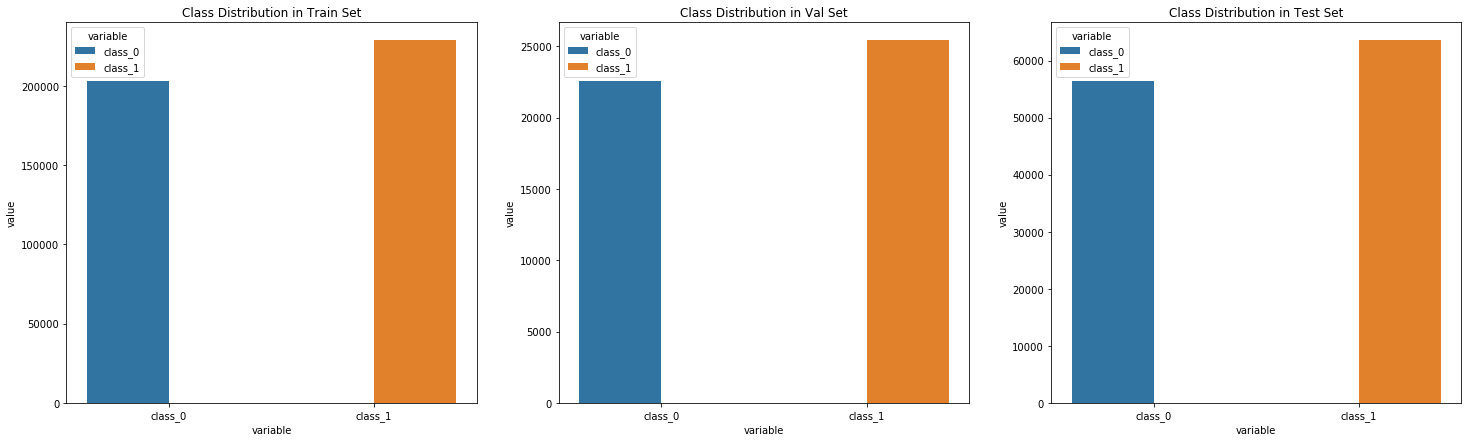

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [20]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [21]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [22]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([4.9177e-06, 4.3735e-06])


In [23]:
class_weights_all = class_weights[target_list]

In [24]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [25]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [26]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [58]:
import torch
from torch import autograd
from torch import nn


class CrossEntropyLoss(nn.Module):
    """
    This criterion (`CrossEntropyLoss`) combines `LogSoftMax` and `NLLLoss` in one single class.
    
    NOTE: Computes per-element losses for a mini-batch (instead of the average loss over the entire mini-batch).
    """
    log_softmax = nn.LogSoftmax()

    def __init__(self):
        super().__init__()
        
    def forward(self, x, target,iteration,e):
        log_softmax =  x - x.exp().sum(-1).log().unsqueeze(-1)
        loss = -log_softmax[range(target.shape[0]), target]
        if iteration%20==0:
            xaxis=list(np.arange(1,BATCH_SIZE))
            temp=sorted(loss.cpu())
            data = [[x_data, y_data] for (x_data, y_data) in zip(xaxis, temp)]
            table = wandb.Table(data=data, columns = ["x", "y"])
            wandb.log({f"Loss epoch{e}" : wandb.plot.line(table, "x", "y",
                       title="Custom Y vs X Line Plot")},step=e)
#             wandb.log({f'Train Loss epoch {e} steps{iteration}':loss}, step=e)
        return loss.mean(), loss.argsort()

In [59]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=28, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [60]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [61]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [62]:
# mean_data=[]
# variance_data=[]
# step_data=[]

In [63]:
def faissQuery(X_train_class, Queries,iteration,e):
    tempbatch=set()
    for i in range(NUM_CLASSES):
        distance, bucket = query(X_train_class[i].shape[1],X_train_class[i].shape[0],len(Queries[i]),False,np.array(Queries[i].cpu()),np.array(Queries[i].cpu()),f'CLASS{i}',NPROBE,NQUERIES)
#             wandb.log({f"Distance Mean epoch {e} steps {iteration}":mean, f'Distance Variance epoch {e} steps{iteration}':res},step=e)
        for j in range(len(bucket)):
            for k in range(len(bucket[j])):
                #print("Class: ", i)
                #print("Query: ", Queries[i][j])
                #print("Neighbor: ", X_train_class[i][int(bucket[j][k])])
                tempbatch.add((int(bucket[j][k]),i))
    return tempbatch

In [64]:
#Should shuffle after creation?
def createBatch(tempbatch, LSHBatching=True):
    if LSHBatching:
        tempbatch=list(tempbatch)
        LSHbatch=random.choices(tempbatch, k=int(BATCH_SIZE/2))
        batchX = [X_train_class[x[1]][x[0]] for x in LSHbatch]
        batchY = [x[1] for x in LSHbatch]
        randomBatch0 = random.choices(X_train_class[0], k=int(BATCH_SIZE/4))
        randomBatch1 = random.choices(X_train_class[1], k=int(BATCH_SIZE/4))
        batchX = np.concatenate((batchX, randomBatch0, randomBatch1))
        batchY= np.concatenate((batchY, [0]*int(BATCH_SIZE/4), [1]*int(BATCH_SIZE/4)))
    else:
        randomBatch0 = random.choices(X_train_class[0], k=int(BATCH_SIZE/2))
        randomBatch1 = random.choices(X_train_class[1], k=int(BATCH_SIZE/2))
        batchX = np.concatenate((randomBatch0, randomBatch1))
        batchY= np.concatenate(([0]*int(BATCH_SIZE/2), [1]*int(BATCH_SIZE/2)))
    
    batchX, batchY = shuffle(batchX, batchY)
    
    return np.array(batchX), np.array(batchY).astype(np.int64)

In [65]:
temp_indices=list(range(0,len(X_train)))
temp_indices=random.choices(temp_indices,k=BATCH_SIZE)

In [66]:
X_train_LSH=X_train[temp_indices]
y_train_LSH=y_train[temp_indices].astype(np.int64)

In [67]:
LSHBatching=True

In [68]:
print("Begin training.")
oldBatch = set()
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    model.train()
    step=0
    for steps in tqdm(range(1, MAX_STEPS+1)):
        X_train_batch= torch.from_numpy(X_train_LSH).to(device)
        y_train_batch=torch.from_numpy(y_train_LSH).to(device)

        ##why ? 
        optimizer.zero_grad()

        #timestampA = time.time()
        y_train_pred = model(X_train_batch.float())
        #print("Time for pred", time.time() - timestampA)

        #timestampB = time.time()
        
        train_loss, sorted_index = criterion(y_train_pred, y_train_batch,steps,e)
        #print("Time for loss", time.time() - timestampB)

        if LSHBatching:
            #PROCEDURE FOR NEW BATCHES
            with torch.no_grad():
                #Find elements in batch that led to top K losses  
                X_train_batch_Topk = X_train_batch[sorted_index[-K:]]
                y_train_batch_Topk = y_train_batch[sorted_index[-K:]]

                #Query Faiss for nearest neighbors
                #timestampC = time.time()
                nextBatch = faissQuery(X_train_class,[X_train_batch_Topk[y_train_batch_Topk == 0], X_train_batch_Topk[y_train_batch_Topk == 1]],steps,e)
                #print("Time for faiss query", time.time() - timestampC)

                #check for being stuck in cluster  
                #print("Similarity to old batch", len(nextBatch.intersection(oldBatch))/len(nextBatch.union(oldBatch)))
                oldBatch = nextBatch

                # Create new batch from neighbors and random sample
                #timestampD = time.time()
                X_train_LSH,y_train_LSH=createBatch(nextBatch)
                #print("Time for batch creation", time.time() - timestampD)

        else:
            with torch.no_grad():
                X_train_LSH,y_train_LSH=createBatch(X_train_batch, LSHBatching)
        ##############################


        train_loss.backward()

        optimizer.step()


        
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        train_epoch_loss=0
        train_epoch_acc=0
        model.eval()
        # VALIDATION LOSS AND ACCURACY
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss, _ = criterion(y_val_pred, y_val_batch,1,e)
            val_acc = multi_acc(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        # TRAIN LOSS AND ACCURACY
        count=0;
        for X_train_batch, y_train_batch in train_loader:
            if count>5:
                break
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

            y_train_pred = model(X_train_batch)

            train_loss, _ = criterion(y_train_pred, y_train_batch,1,e)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
            count+=1;
            
    loss_stats['train'].append(train_epoch_loss/(count+1))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/(count+1))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/(count+1):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/(count+1):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    wandb.log({"Train Loss":train_epoch_loss/(count+1), "Val Loss":val_epoch_loss/len(val_loader),"Train Accuracy":train_epoch_acc/(count+1),"Val Accuracy":val_epoch_acc/len(val_loader)}, step=e)

Begin training.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.58905 | Val Loss: 0.69226 | Train Acc: 47.429| Val Acc: 52.360


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 002: | Train Loss: 0.59530 | Val Loss: 0.69181 | Train Acc: 40.714| Val Acc: 52.625


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 003: | Train Loss: 0.59400 | Val Loss: 0.68883 | Train Acc: 44.286| Val Acc: 53.938


In [61]:

# print("Begin training.")
# for e in tqdm(range(1, EPOCHS+1)):

#   # TRAINING
#   train_epoch_loss = 0
#   train_epoch_acc = 0
#   model.train()
#   for X_train_batch, y_train_batch in train_loader:
#       X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
#       optimizer.zero_grad()
#       y_train_pred = model(X_train_batch)

#       train_loss, _ = criterion(y_train_pred, y_train_batch)
#       train_acc = multi_acc(y_train_pred, y_train_batch)


#       train_loss.backward()
#       optimizer.step()

#       train_epoch_loss += train_loss.item()
#       train_epoch_acc += train_acc.item()


#   # VALIDATION    
#   with torch.no_grad():

#       val_epoch_loss = 0
#       val_epoch_acc = 0

#       model.eval()
#       for X_val_batch, y_val_batch in val_loader:
#           X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

#           y_val_pred = model(X_val_batch)

#           val_loss, _ = criterion(y_val_pred, y_val_batch)
#           val_acc = multi_acc(y_val_pred, y_val_batch)

#           val_epoch_loss += val_loss.item()
#           val_epoch_acc += val_acc.item()
#   loss_stats['train'].append(train_epoch_loss/len(train_loader))
#   loss_stats['val'].append(val_epoch_loss/len(val_loader))
#   accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
#   accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


#   print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

In [152]:
%pdb off

Automatic pdb calling has been turned OFF


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

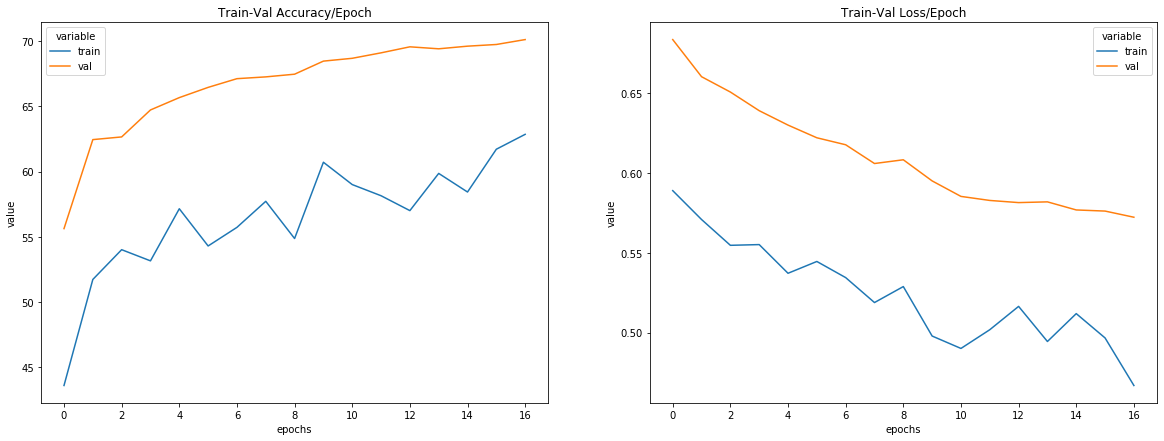

In [34]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

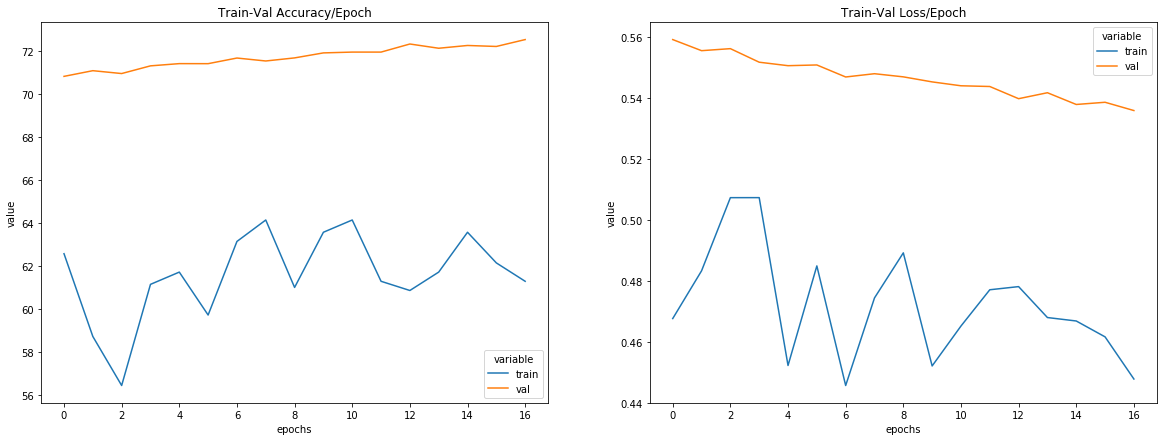

In [39]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [184]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [185]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

NameError: name 'idx2class' is not defined

In [ ]:
print(classification_report(y_test, y_pred_list))